# Predict Coca Cola Stock Price using Regression and ARIMA

Import libraries and read the file. Set the index to the data column and parse the dates

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  
import pandas as pd  
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('KODailyPrice.csv',index_col=0, parse_dates=[0])
plt.rcParams['figure.figsize'] = [12, 4]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14990 entries, 1962-01-02 to 2021-07-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       14990 non-null  float64
 1   High       14990 non-null  float64
 2   Low        14990 non-null  float64
 3   Close      14990 non-null  float64
 4   Adj Close  14990 non-null  float64
 5   Volume     14990 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 819.8 KB


View the first 5 rows of data

In [23]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051918,806400
1962-01-03,0.259115,0.259115,0.253255,0.257161,0.050762,1574400
1962-01-04,0.257813,0.261068,0.257813,0.259115,0.051147,844800
1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049991,1420800
1962-01-08,0.251302,0.251302,0.245768,0.250651,0.049477,2035200


There weren't any null values to clean up and the datatype are float and integers which are appropriate for our analysis. 
Below is a heatmap that shows the correlation values between Open, High, Low, close and volume. There is a very strong correlation between the prices which can also be seen in the plot of prices.

Text(0.5, 1.0, 'Coca Cola stock Open, Closing, High and Low prices')

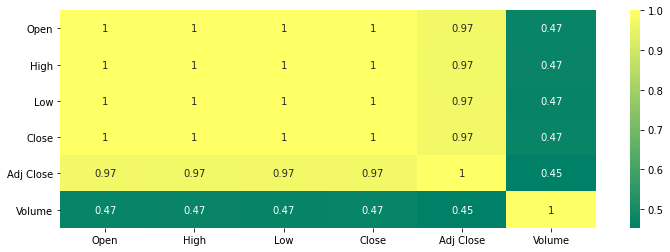

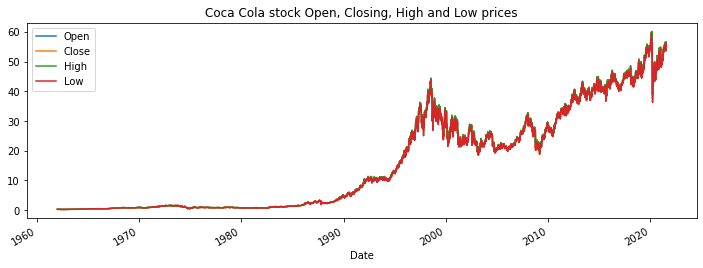

In [24]:
sns.heatmap(df.corr(), annot=True, cmap='summer')
df[['Open', 'Close', 'High', 'Low']].plot()
plt.title('Coca Cola stock Open, Closing, High and Low prices')

Drop all predictor variables except closing price

In [25]:
df = df['Close']

Use linear regression to view the trend of the data. 
Calculate the R^2 which shows how well the data fit. 

R^2: 0.8357892241009401


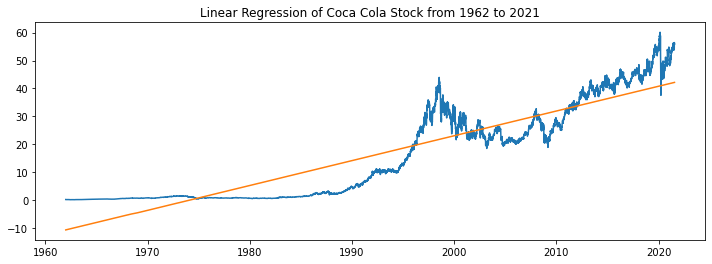

In [26]:
from sklearn.linear_model import LinearRegression
lr = df.reset_index()
x = np.array(lr.index).reshape(-1, 1)
y = df
linreg = LinearRegression().fit(x, y)
linreg.score(x, y)
predictions = linreg.predict(x)
plt.plot(df)
plt.title('Linear Regression of Coca Cola Stock from 1962 to 2021') 
plt.plot(df.index, predictions)
print('R^2:', linreg.score(x, y))

Evaluate whether the fit would improve if only analyzing 1990 to 2021 and suprisingly the R^2 was worse. 

R^2: 0.7746878771421214


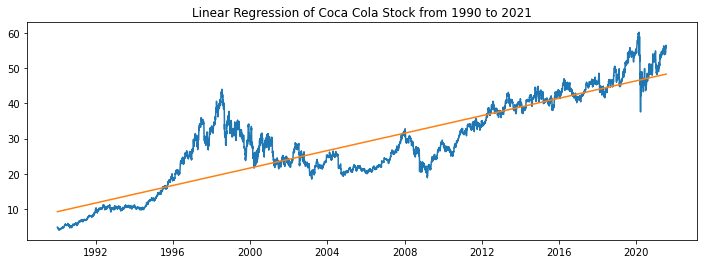

In [27]:
dfy =df['1990':'2021']
lr = dfy.reset_index()
x = np.array(lr.index).reshape(-1, 1)
y = dfy
linreg = LinearRegression().fit(x, y)
linreg.score(x, y)
predictions = linreg.predict(x)
plt.plot(dfy)
plt.title('Linear Regression of Coca Cola Stock from 1990 to 2021') 
plt.plot(dfy.index, predictions)
print('R^2:', linreg.score(x, y))

Resample the dataset to weekly with the weeks beginning on Mondays

In [28]:
df = df.resample('W-MON').mean()

Evaluate Stationarity using the Augmented Dickey Fuller test which shows a very high p-value confirming non-stationarity

In [29]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.831106
p-value: 0.992122


The p-value is greater than 0.05 so I will take the difference and observe the ACF and PACF plots to improve stationarity

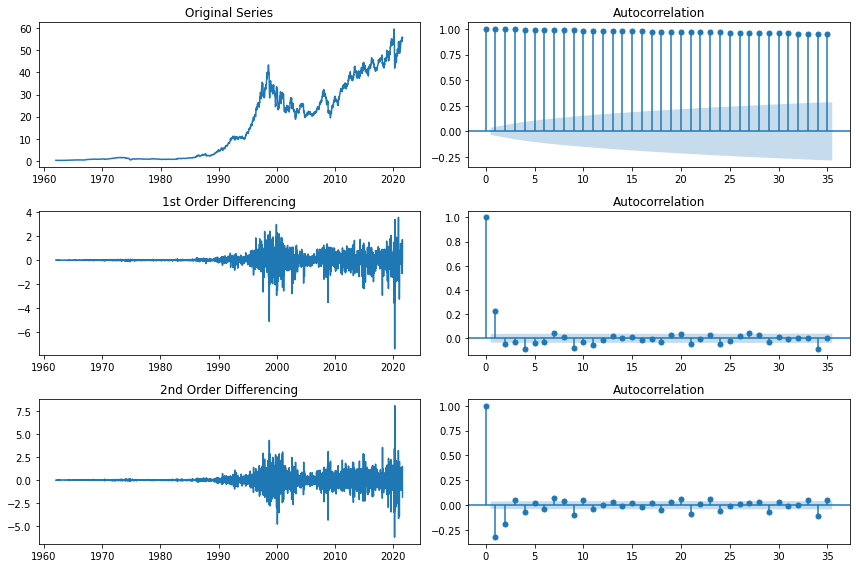

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, ax=axes[0, 1])

axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[1, 1])

axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('2nd Order Differencing') 
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1])
plt.tight_layout()


In [31]:
from pmdarima.arima.utils import ndiffs
ndiffs(df.dropna(),test='adf')

1

Low p-value indicates stationarity which is a requirement for ARIMA

In [32]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -12.857528
p-value: 0.000000


Decompose the data to look for stationarity. The decomposed time series shows the upward trend
seasonality is apparent but there are no apparent trends in the residuals.
Regression Analysis shows trend. R^2 shows the goodness of fit.

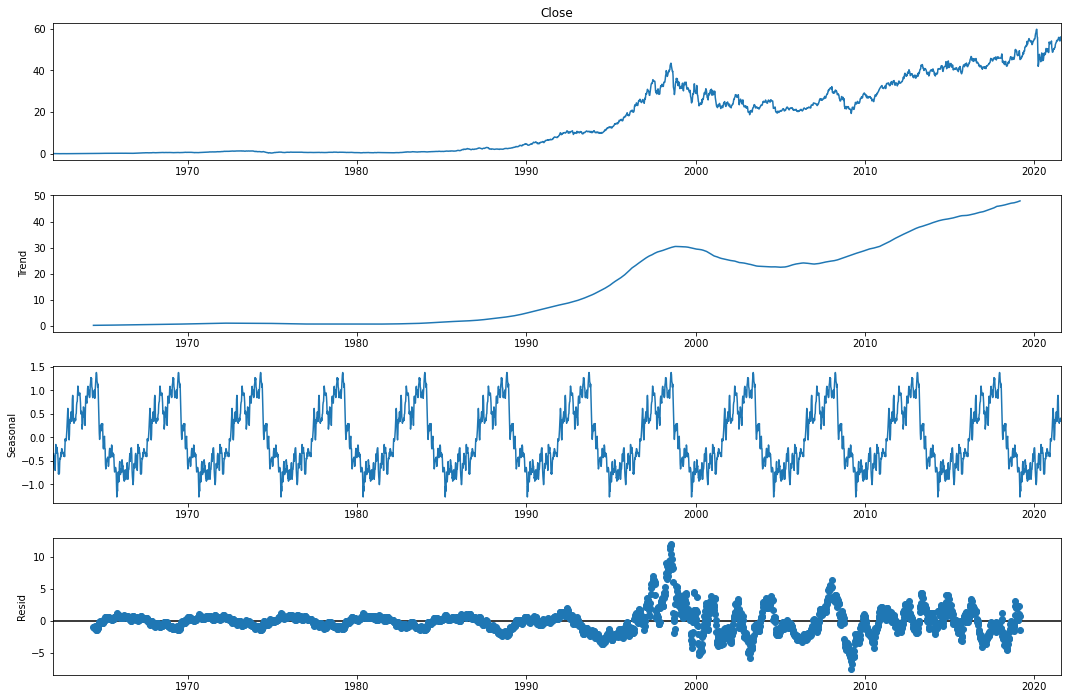

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
time_series=df.dropna()
type(time_series)
decomp= seasonal_decompose(time_series,period=253)
fig= decomp.plot()
fig.set_size_inches(15,10)

The ACF plots, ndiffs and low p-value calculated from the Augmented Dickey Fuller Test confirmed that the best value for d is 1 The PACF plot shows the correlation between the series and its lags. p shows the order of the AR term indicating the number of lags to be used as predictors. It appears that the best value for p is 2. The ACF plot can be used to find the best value for q. q is the order of the moving average. From the ACF is appears that 2 if the best value

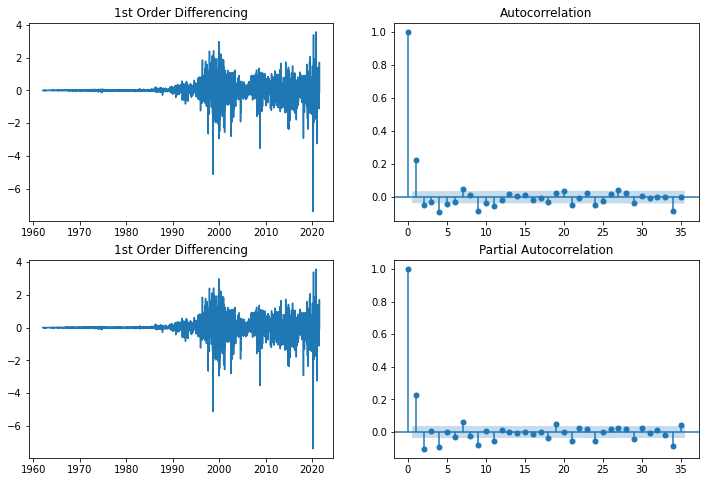

In [34]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(df.diff()); axes[0, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), ax=axes[0, 1])

axes[1, 0].plot(df.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(df.diff().dropna(), ax=axes[1, 1]);

Split the dataset into training and testing sets

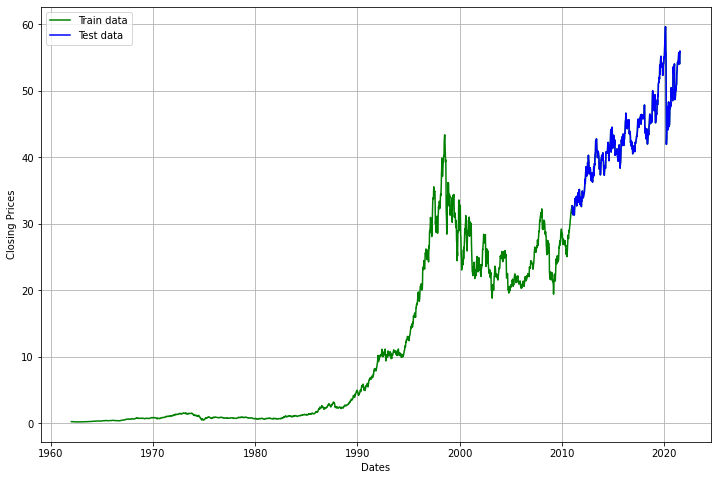

In [35]:
df=df['1960':'2021'] 
#train, test = df[1:int(len(df)*0.80)], df[int(len(df)*0.80):]
test =df['2011':'2021']
train=df['1960':'2010']
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test, 'blue', label='Test data')
plt.legend()

Build the ARIMA model on the training dataset, forecast and plot it.

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2555
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1373.833
Method:                       css-mle   S.D. of innovations              0.414
Date:                Fri, 01 Oct 2021   AIC                           2755.666
Time:                        18:34:20   BIC                           2779.050
Sample:                    01-15-1962   HQIC                          2764.146
                         - 12-27-2010                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0127      0.010      1.265      0.206      -0.007       0.032
ar.L1.D.Close    -0.1349      0.080     -1.687      0.092      -0.292       0.022
ma.L1.D.Close     0.3927      0.075     

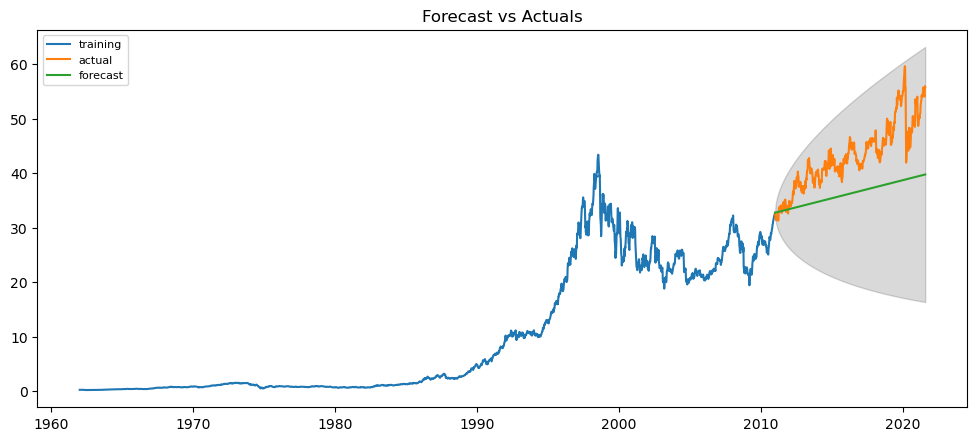

In [37]:
from statsmodels.tsa.arima_model import ARIMA
df = df.dropna()
model = ARIMA(train, order=(1,1,1), freq='W-MON')
model_fit = model.fit(disp=0,maxiter=100)
print(model_fit.summary())
fc, se, conf = model_fit.forecast(552, alpha=0.05)  

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [38]:
mape = np.mean(np.abs(fc_series - test)/np.abs(test))
mape

0.1512475890355924

A MAPE of 0.15% implies that the model is 85% accurate in predicting the next observations.

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 2554
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1387.270
Method:                       css-mle   S.D. of innovations              0.416
Date:                Fri, 01 Oct 2021   AIC                           2782.541
Time:                        18:34:35   BIC                           2805.922
Sample:                    01-22-1962   HQIC                          2791.020
                         - 12-27-2010                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.219e-05   1.46e-05      0.835      0.404   -1.64e-05    4.08e-05
ar.L1.D2.Close     0.2366      0.019     12.302      0.000       0.199       0.274
ma.L1.D2.Close    -1.0000      0.001

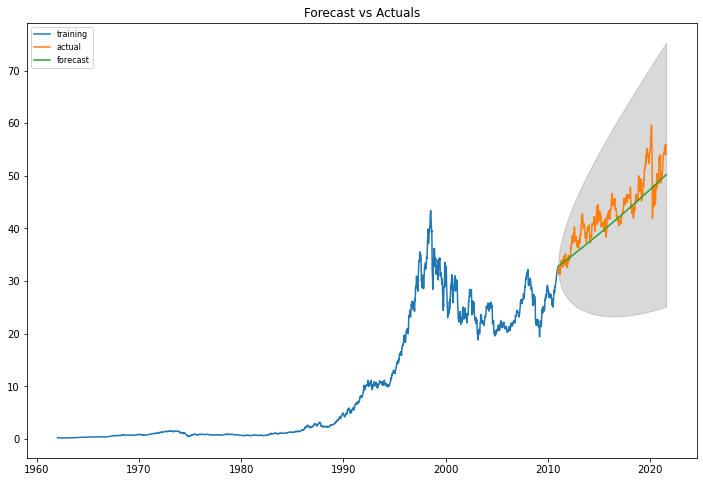

In [39]:
from statsmodels.tsa.arima_model import ARIMA
df = df.dropna()
model = ARIMA(train, order=(1,2,1), freq='W-MON')
model_fit = model.fit(disp=0,maxiter=100)
print(model_fit.summary())
 
fc, se, conf = model_fit.forecast(552, alpha=0.05) 
 
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The ARIMA model with parameters set at (1,2,1) predict within the 95% confidence interval. The p-values for AR and MA are less than 0.05. The AIC value improved when (1,2,1) parameters were used.

In [40]:
mape = np.mean(np.abs(fc_series - test)/np.abs(test))
mape

0.053324336352552286

A MAPE of 0.05% implies that the model is 95% accurate in predicting the next observations.